In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from geopy.geocoders import Nominatim
from collections import Counter
import os
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
import random
import operator

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, TweetTokenizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
import string
%matplotlib inline
plt.style.use('ggplot')
# plt.style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, make_scorer, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor


## Read in csv data and get into dataframe

In [2]:
def read_tweets(filename):
    df = pd.read_csv(filename)
    return df

In [3]:
filenames = []
for file in os.listdir("data3/"):
    if file.endswith(".csv"):
        filenames.append(os.path.join("data3/", file))

In [63]:
dfs = []
for filename in filenames:
    df = read_tweets(filename)
    df = df.iloc[:,:8]
    df.columns = ['username','date','retweets','favorites','text','geo','mentions','hashtags']
    dfs.append(df)

In [152]:
dfs_to_use = []
for df in dfs:
    df['date'] = pd.to_datetime(df['date'])
    if df['date'].min() < pd.to_datetime('2016/11/03'):
        dfs_to_use.append(df)
        print 'start date = {}'.format(df['date'].min())
        print 'end date = {}'.format(df['date'].max())

start date = 2016-11-01 07:58:00
end date = 2017-10-25 12:32:00
start date = 2016-11-01 17:07:00
end date = 2017-10-19 17:37:00
start date = 2016-11-02 05:22:00
end date = 2017-10-21 23:24:00
start date = 2016-11-01 02:15:00
end date = 2017-10-25 23:35:00
start date = 2016-11-01 07:58:00
end date = 2017-10-23 15:42:00
start date = 2016-11-01 02:15:00
end date = 2017-10-25 23:35:00
start date = 2016-11-01 15:41:00
end date = 2017-10-25 11:03:00
start date = 2016-11-01 15:41:00
end date = 2017-10-25 11:03:00
start date = 2016-11-01 05:48:00
end date = 2017-10-25 05:28:00
start date = 2016-11-01 07:58:00
end date = 2017-10-25 12:32:00
start date = 2016-11-02 20:17:00
end date = 2017-10-19 15:55:00
start date = 2016-11-02 11:24:00
end date = 2017-10-02 16:41:00
start date = 2016-11-01 16:53:00
end date = 2017-10-20 17:29:00
start date = 2016-11-01 05:20:00
end date = 2017-10-21 15:39:00
start date = 2016-11-01 07:58:00
end date = 2017-10-25 12:32:00
start date = 2016-11-01 15:41:00
end dat

In [248]:
data = dfs_to_use[0].append(dfs_to_use[1:])

## Cleaning data

In [250]:
data = data[(data['text'].str.len()<=140)&(data['text'].str.len()>0)]

In [251]:
data.drop_duplicates(['date','text'],inplace=True)
data = data[data['username']!='kpc']
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30938 entries, 0 to 1097
Data columns (total 8 columns):
username     30938 non-null object
date         30938 non-null datetime64[ns]
retweets     30938 non-null int64
favorites    30938 non-null int64
text         30938 non-null object
geo          72 non-null object
mentions     25004 non-null object
hashtags     2954 non-null object
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 2.1+ MB


In [252]:
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['dayofweek'] = data['date'].dt.dayofweek
data['hour'] = data['date'].dt.hour
data['date2'] = data['date'].dt.date

In [253]:
data['retweeted'] = np.where(data['retweets']>0,1,0)
data['retweeted'].sum()/float(len(data['retweeted']))

0.08497640442174671

In [ ]:
data.to_csv('data_output/kplc_tweets.csv')

# Exploring data

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

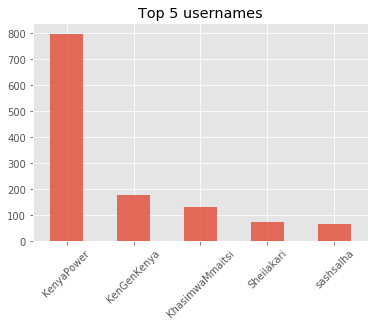

In [254]:
data['username'].value_counts()[:5].plot(kind='bar',figsize=(6,4), title='Top 5 usernames',alpha=0.8)
plt.xticks(rotation=45)

Separate out the Kenya Power Tweets

In [257]:
data_kplc = data[data['username'].isin(['KenyaPower','KenGenKenya'])]
data = data[~data['username'].isin(['KenyaPower','KenGenKenya'])]

In [258]:
data_kplc.to_csv('data_output/kplc_company_tweets.csv')
data.to_csv('data_output/kplc_customer_tweets.csv')

### Retweet distribution

Text(0,0.5,u'Number of tweets')

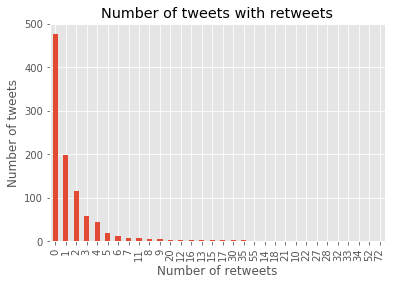

In [256]:
data_kplc['retweets'].value_counts().plot(kind='bar',title='Number of tweets with retweets')
plt.xlabel('Number of retweets')
plt.ylabel('Number of tweets')

Text(0,0.5,u'Number of tweets')

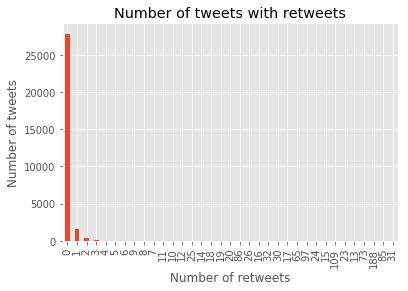

In [90]:
data['retweets'].value_counts().plot(kind='bar',title='Number of tweets with retweets')
plt.xlabel('Number of retweets')
plt.ylabel('Number of tweets')

### Tweet count by month

Text(0.5,1,u'Number of tweets per month')

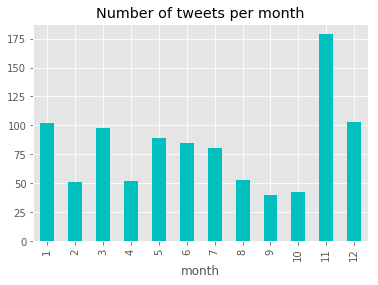

In [87]:
data_kplc.groupby('month')['date'].count().plot(kind='bar',color='c')
plt.title('Number of tweets per month')

Text(0.5,1,u'Number of tweets per month')

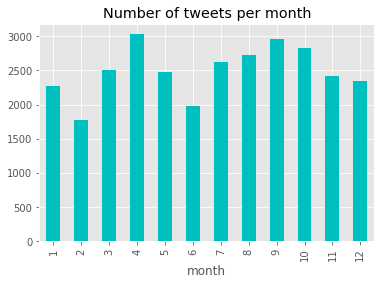

In [91]:
data.groupby('month')['date'].count().plot(kind='bar',color='c')
plt.title('Number of tweets per month')

### Tweet count by Day of Week

Text(0.5,1,u'Number of tweets per day of the week')

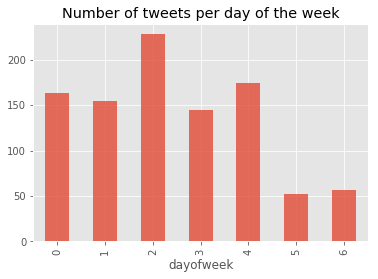

In [110]:
data_kplc.groupby('dayofweek')['date'].count().plot(kind='bar',alpha=0.8)
plt.title('Number of tweets per day of the week')

Text(0.5,1,u'Number of tweets per day of the week')

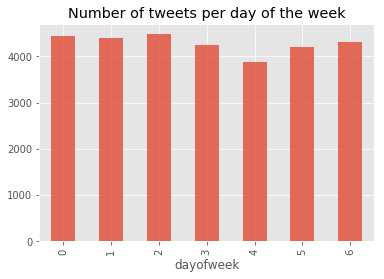

In [111]:
data.groupby('dayofweek')['date'].count().plot(kind='bar',alpha=0.8)
plt.title('Number of tweets per day of the week')

### Tweet count by Hour of Day

Text(0.5,1,u'Number of tweets by hour of the day')

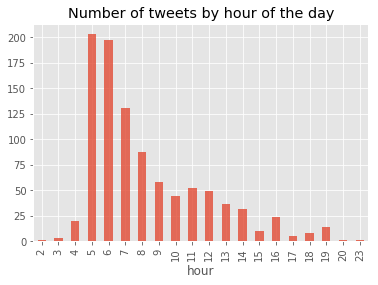

In [106]:
data_kplc.groupby('hour')['date'].count().plot(kind='bar',alpha=0.8)
plt.title('Number of tweets by hour of the day')

Text(0.5,1,u'Number of tweets by hour of the day')

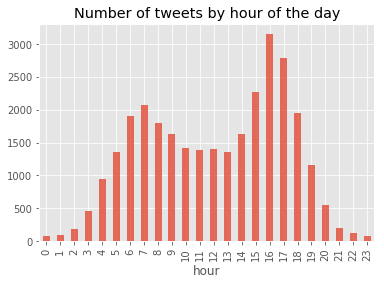

In [107]:
data.groupby('hour')['date'].count().plot(kind='bar',alpha=0.8)
plt.title('Number of tweets by hour of the day')

### Tweet count by Day of Year

Text(0.5,1,u'Number of tweets over time')

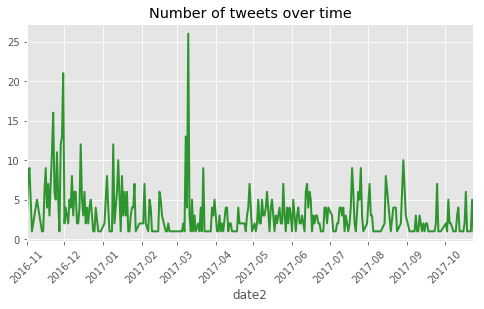

In [127]:
data_kplc.groupby('date2')['date'].count().plot(kind='line',figsize=(8,4),linewidth=2,alpha=0.8, c='g')
plt.xticks(rotation=45)
plt.title('Number of tweets over time')

Text(0.5,1,u'Number of tweets over time')

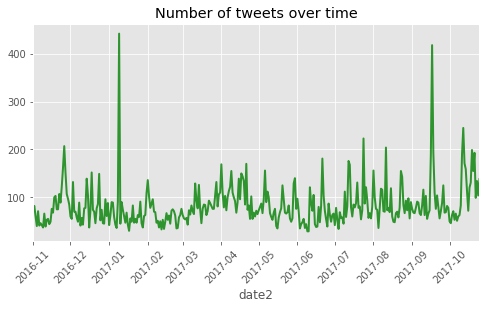

In [128]:
data.groupby('date2')['date'].count().plot(kind='line',figsize=(8,4),linewidth=2,alpha=0.8, c='g')
plt.xticks(rotation=45)
plt.title('Number of tweets over time')

Text(0.5,1,u'Number of retweets over time')

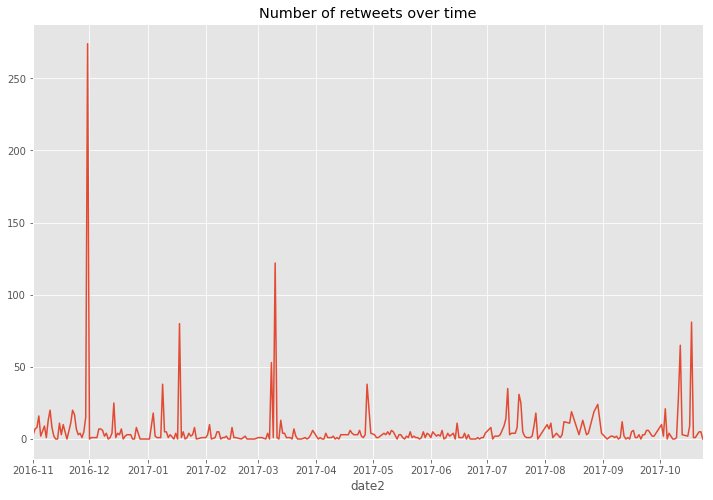

In [103]:
data_kplc.groupby('date2')['retweets'].sum().plot(kind='line',figsize=(12,8))
plt.title('Number of retweets over time')

Text(0.5,1,u'Number of retweets over time')

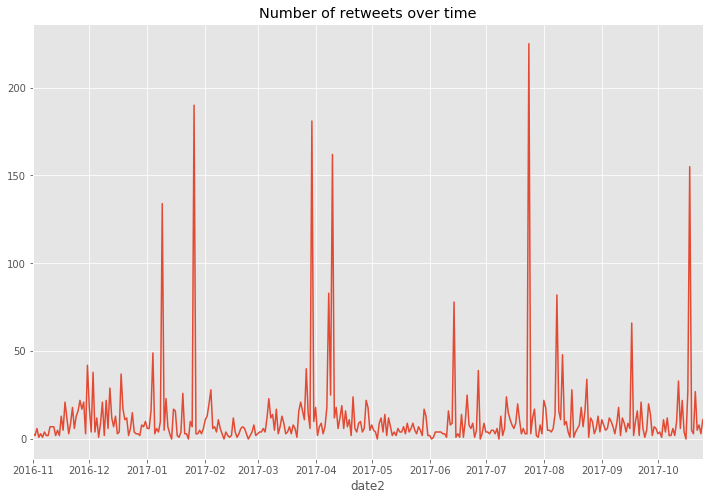

In [99]:
data.groupby('date2')['retweets'].sum().plot(kind='line',figsize=(12,8))
plt.title('Number of retweets over time')

Text(0.5,1,u'Number of tweets over time')

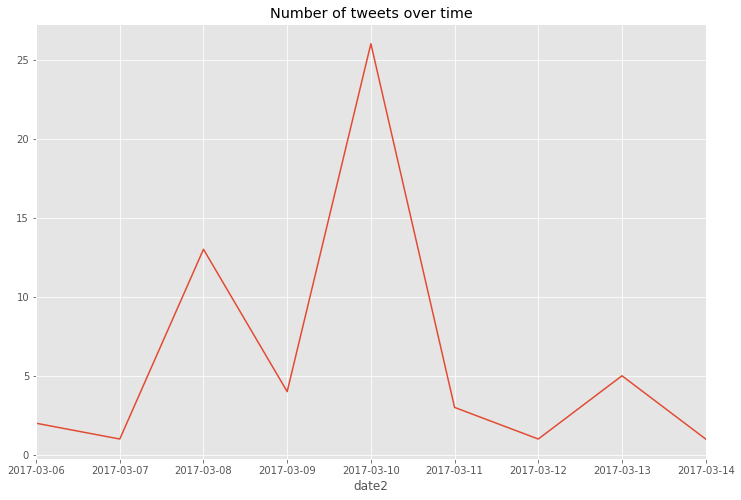

In [141]:
data_kplc[(data_kplc['date2']>pd.to_datetime('2017-3-5').date())&(data_kplc['date2']<pd.to_datetime('2017-3-15').date())].groupby('date2')['date'].count().plot(kind='line',figsize=(12,8))
plt.title('Number of tweets over time')

In [148]:
unique = data['mentions'].unique()
individual = []
for collection in unique:
    sub_list = str(collection).split(' ')
    individual.extend(sub_list)

mention_count = Counter(individual)
top_three_mentions = mention_count.most_common(20)[:3]
top_three_mentions

[('@KenyaPower', 1204), ('@KenyaPower_Care', 688), ('@KenyaPowerAlert', 331)]

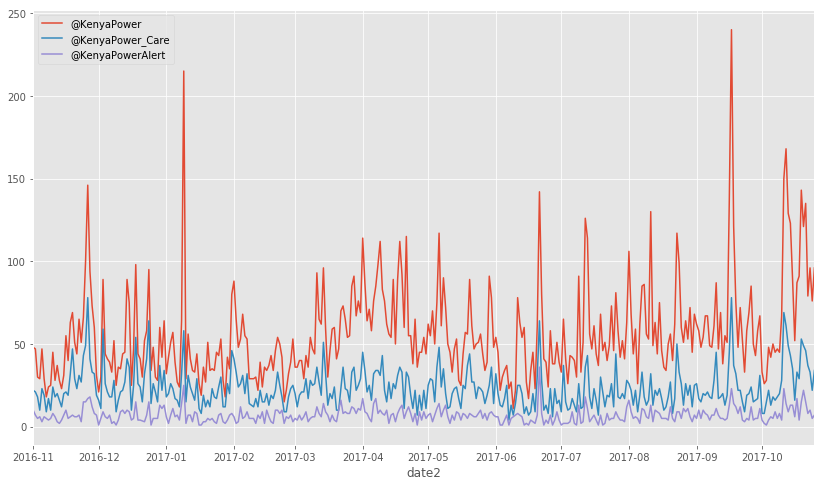

In [149]:
for mention in top_three_mentions:
    temp = data[data['mentions'].str.contains(mention[0],na=False)]
    temp.groupby('date2')['date'].count().plot(kind='line',figsize=(14,8),label=mention[0])
plt.legend(loc='best')
plt.show()

In [150]:
unique = data['hashtags'].unique()
individual = []
for collection in unique:
    sub_list = str(collection).split(' ')
    individual.extend(sub_list)

hashtag_count = Counter(individual)
top_three_hashtags = hashtag_count.most_common(20)[:3]
top_three_hashtags

[('#KPLC', 56), ('#kenyapower', 55), ('#kplc', 50)]

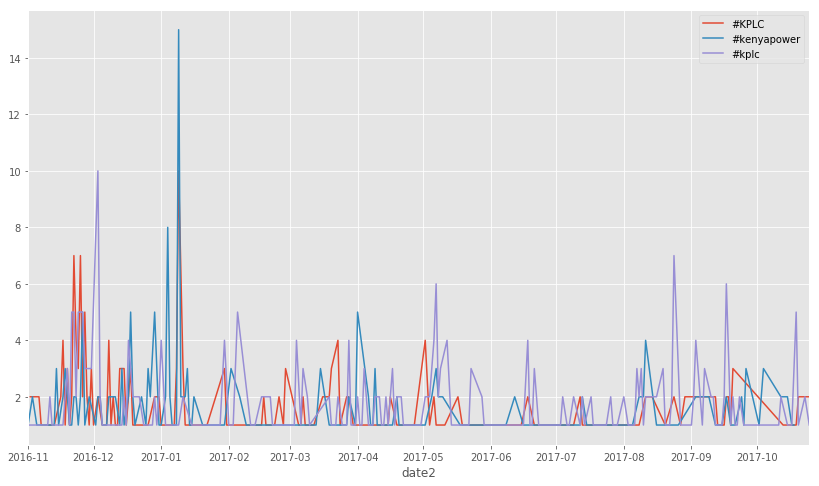

In [151]:
for hashtag in top_three_hashtags:
    temp = data[data['hashtags'].str.contains(hashtag[0],na=False)]
    temp.groupby('date2')['date'].count().plot(kind='line',figsize=(14,8),label=hashtag[0])
plt.legend(loc='best')
plt.show()

In [159]:
tweets = data['text'].values
word_counts = Counter()
for tweet in tweets:
    word_list = tweet.split(' ')
    word_list = [w.lower() for w in word_list if w.isalpha()]
    word_list = [w for w in word_list if w not in STOPWORDS]
    counts = Counter(word_list)
    word_counts += counts


In [163]:
def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(10, 50)
wc = WordCloud(background_color="white", max_words=200,
               stopwords=STOPWORDS, max_font_size=300, random_state=42)
wc.generate_from_frequencies(word_counts)
wc.recolor(color_func=grey_color_func, random_state=3)
wc.to_file("kplc_wordcloud2.png")

![wordcloud](kplc_wordcloud2.png)

In [173]:
word_counts.most_common(10)

[('power', 15051),
 ('since', 5965),
 ('please', 3041),
 ('kindly', 2963),
 ('lights', 2175),
 ('area', 2073),
 ('yesterday', 1907),
 ('blackout', 1904),
 ('last', 1793),
 ('now', 1594)]

In [181]:
data['text'].str.contains('lights').sum()/float(len(data))

0.073598810524274361

## Building a topic modeller

In [259]:
def build_text_vectorizer(contents, use_stemmer=False, max_features=None, use_tfidf=True):
    '''
    Build and return a **callable** for transforming text documents to vectors,
    as well as a vocabulary to map document-vector indices to words from the
    corpus. The vectorizer will be trained from the text documents in the
    `contents` argument. If `use_tfidf` is True, then the vectorizer will use
    the Tf-Idf algorithm, otherwise a Bag-of-Words vectorizer will be used.
    The text will be tokenized by words, and each word will be stemmed iff
    `use_stemmer` is True. If `max_features` is not None, then the vocabulary
    will be limited to the `max_features` most common words in the corpus.
    '''
    if use_tfidf==True:
        Vectorizer = TfidfVectorizer
    else:
        Vectorizer = CountVectorizer
#     tokenizer = RegexpTokenizer(r"[\w']+")
    tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
    stem = PorterStemmer().stem if use_stemmer else (lambda x: x)
    stop_set = set(stopwords.words('english'))

    # Closure over the tokenizer et al.
    def tokenize(text):
        tokens = tokenizer.tokenize(text)
        stems = [stem(token) for token in tokens if token not in stop_set]
        punctuations = list(string.punctuation)
        stems = [s for s in stems if s not in punctuations]
        stems = [s.lower() for s in stems if s.isalpha()]
        return stems

    vectorizer_model = Vectorizer(tokenizer=tokenize, max_features=max_features)
    vectorizer_model.fit(contents)
    vocabulary = np.array(vectorizer_model.get_feature_names())

    # Closure over the vectorizer_model's transform method.
    def vectorizer(X):
        return vectorizer_model.transform(X).toarray()

    return vectorizer, vocabulary

In [260]:
def display_topics(H, W, feature_names, documents, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print "Topic %d:" % (topic_idx)
        print " ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]])
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            print documents[doc_index]

In [261]:
text = data['text'].values

In [262]:
vect, vocab = build_text_vectorizer(text, use_stemmer=True, max_features=150, use_tfidf=False)


In [263]:
tfidf = vect(text)

In [264]:
tfidf.shape

(29964, 150)

In [265]:
nmf = NMF(n_components=3, max_iter=200, alpha=0.00001)
W = nmf.fit_transform(tfidf)
H = nmf.components_

In [266]:
data['main_topic'] = W.argmax(axis=1)
data.to_csv('data_output/kplc_customer_with_topics.csv')

Text(0.5,1,u'Count of tweet by topic per day')

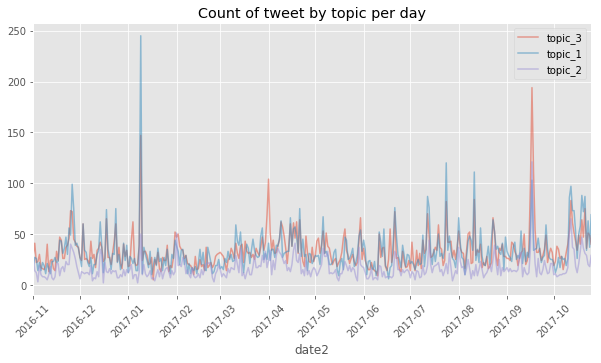

In [228]:
for topic in data['main_topic'].unique():
    data[data['main_topic']==topic].groupby('date2')['username'].count().plot(kind='line',figsize=(10,5),alpha=0.5, label='topic_'+str(topic+1))
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.title('Count of tweet by topic per day')

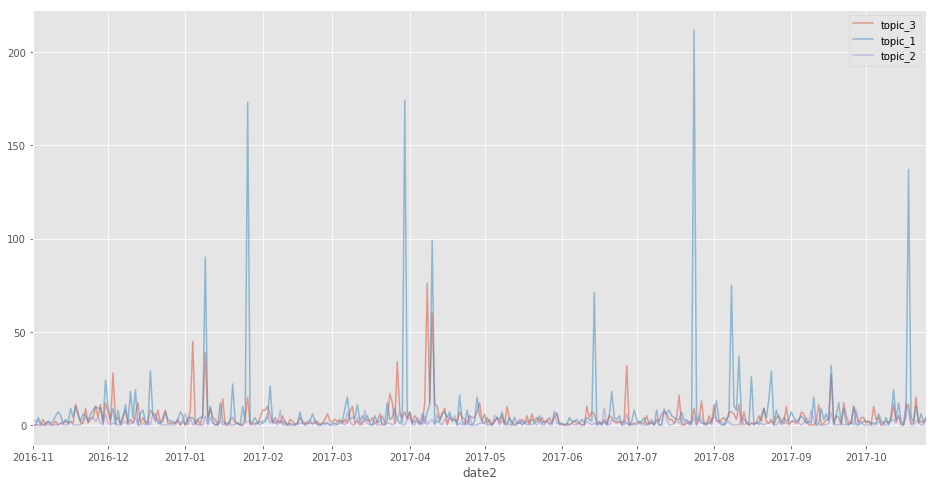

In [229]:
for topic in data['main_topic'].unique():
    data[data['main_topic']==topic].groupby('date2')['retweets'].sum().plot(kind='line',figsize=(16,8),alpha=0.5, label='topic_'+str(topic+1))
plt.legend(loc='best')

In [230]:
display_topics(H,W,vocab,text,5,5)

Topic 0:
power outag restor kenya area
@KenyaPower no power, no power at mageche....Kenya power do something to restore power...too much darkness...
No power no power no power. Restore power Karen rhinopark 61366-01.
@KenyaPower when are we expecting power back, it has been 4 days in Aviation without Power. We see Kenya power as from 5pm site all invain
@KenyaPower Kenya Power!!!What's happening with power in Ongata Rongai? No power from10am..nkt..Are we now going to wait until 2am.Disgust C
Kenya power you are letting us down no power seens yesterday. What is happening we truly need power, our business are not working now.
Topic 1:
sinc yesterday morn night light
@KenyaPower Good morning no lights since yesterday morning.. Mt no 14106799464 Ruai Kamullu.. Ruai office is not helping been calling since
No power since yesterday 4PM. You've been sending technicians since yesterday!! Ref No 3554066
@KenyaPower Account No. 01450552581 no power since yesterday. Most Prudential Est houses and

In [231]:
def hand_label_topics(H, vocabulary):
    '''
    Print the most influential words of each latent topic, and prompt the user
    to label each topic. The user should use their humanness to figure out what
    each latent topic is capturing.
    '''
    hand_labels = []
    for i, row in enumerate(H):
        top_five = np.argsort(row)[::-1][:5]
        print 'topic', i
        print '-->', ' '.join(vocabulary[top_five])
        label = raw_input('please label this topic: ')
        hand_labels.append(label)
        print
    return hand_labels


In [47]:
hand_labels = hand_label_topics(H, vocab)

topic 0
--> power outag restor kenya day
please label this topic: outagecomplaint

topic 1
--> sinc yesterday morn light night
please label this topic: temporalreference

topic 2
--> area http today nairobi morn
please label this topic: kplcannouncement

topic 3
--> pleas kindli token assist day
please label this topic: token issues



In [48]:
vocab

array([u'ac', u'acc', u'account', u'address', u'advis', u'affect', u'ago',
       u'along', u'area', u'around', u'asap', u'assist', u'b', u'back',
       u'bill', u'black', u'blackout', u'bought', u'busi', u'c', u'call',
       u'care', u'cc', u'check', u'come', u'connect', u'counti', u'custom',
       u'dark', u'day', u'done', u'electr', u'embakasi', u'environ',
       u'estat', u'even', u'everi', u'experienc', u'fix', u'follow',
       u'get', u'give', u'go', u'good', u'guy', u'happen', u'hello',
       u'help', u'hey', u'hi', u'hour', u'hous', u'hr', u'http',
       u'interrupt', u'issu', u'kahawa', u'kasarani', u'keep', u'kenya',
       u'kindli', u'kisumu', u'know', u'kplc', u'langata', u'last',
       u'light', u'like', u'line', u'long', u'mainten', u'meter', u'metr',
       u'mombasa', u'month', u'morn', u'mpesa', u'mtr', u'much', u'n',
       u'na', u'nairobi', u'near', u'need', u'next', u'night', u'noth',
       u'number', u'offic', u'one', u'outag', u'paid', u'part', u'past',

In [245]:
for value in data.groupby('main_topic')['text'].count():
    print value/float(30966)

0.383775754053
0.192275398825
0.391590776981


In [247]:
data.groupby('main_topic')['text'].count()

main_topic
0    11884
1     5954
2    12126
Name: text, dtype: int64

### Train topic classification model...

In [232]:
X = tfidf
y = W.argmax(axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y)


In [233]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)
print 'training accuracy: {}'.format(rfc.score(X_train, y_train))
print 'testing accuracy: {}'.format(rfc.score(X_test, y_test))
y_pred = rfc.predict(X_test)

training accuracy: 0.998442575535
testing accuracy: 0.977840074756


In [234]:
cv_accuracy = cross_val_score(rfc, X_train, y_train, cv=5)
print 'cross validated accuracy: {}'.format(cv_accuracy.mean())

cross validated accuracy: 0.973078676142


In [240]:
for i in xrange(3):
    true = y_test == i
    pred = y_pred ==i
    print 'topic {} accuracy: {}'.format(i, accuracy_score(true, pred))
    print 'topic {} f1: {}'.format(i, f1_score(true, pred))

topic 0 accuracy: 0.986784140969
topic 0 f1: 0.983347350715
topic 1 accuracy: 0.989720998532
topic 1 f1: 0.975328420378
topic 2 accuracy: 0.979175010012
topic 2 f1: 0.973630831643


### Train retweet classification

In [402]:
for i in xrange(4):
    data['topic_'+str(i)] = np.where(data['main_topic']==i,1,0)
for i in xrange(7):
    data['dow_'+str(i)] = np.where(data['dayofweek']==i,1,0)
for i in xrange(24):
    data['hour_'+str(i)] = np.where(data['hour']==i,1,0)

In [403]:
cols_to_include = data.columns[31:]

In [404]:
topics = data[cols_to_include].values
# topics = topics.reshape(len(topics),3)
X = np.concatenate((tfidf,topics),axis=1)
y = data['retweeted'].values

In [405]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [406]:
class_imbalance = y.sum()/float(len(y))
print 'number not retweeted: {}%'.format((1-class_imbalance)*100)
print 'number retweeted: {}%'.format(class_imbalance*100)

number not retweeted: 91.5484823205%
number retweeted: 8.45151767952%


In [407]:
# Address class imbalance:
# Random under sampling
no_retweet_idx = []
for i in range(len(y_train)):
    if y_train[i]==0:
        no_retweet_idx.append(i)
under_sample_idx = np.random.choice(no_retweet_idx, size=len(no_retweet_idx)/4,replace=False)
# Random over sampling
retweet_idx = []
for i in range(len(y_train)):
    if y_train[i]==1:
        retweet_idx.append(i)
over_sample_idx = np.random.choice(retweet_idx, size=len(retweet_idx)*2,replace=True)
# Random over sampling

In [408]:
print len(under_sample_idx)
print len(over_sample_idx)
print len(np.concatenate((over_sample_idx,under_sample_idx),axis=0))
new_idx = np.concatenate((over_sample_idx,under_sample_idx),axis=0)

5343
3998
9341


In [409]:
X_train_balance = X_train[new_idx,:]
y_train_balance = y_train[new_idx]
print y_train_balance.sum()/float(len(y_train_balance))
print y_train.sum()/float(len(y_train))

0.428005566856
0.0855223752888


In [414]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train_balance, y_train_balance)
print 'training accuracy: {}'.format(rfc.score(X_train_balance, y_train_balance))
print 'testing accuracy: {}'.format(rfc.score(X_test, y_test))
y_pred = rfc.predict(X_test)
print 'testing f1: {}'.format(f1_score(y_test, y_pred))
print 'testing recall: {}'.format(recall_score(y_test, y_pred))
print 'testing precision: {}'.format(precision_score(y_test, y_pred))

training accuracy: 0.984369981801
testing accuracy: 0.839065708419
testing f1: 0.21625
testing recall: 0.272440944882
testing precision: 0.179274611399


In [411]:
features = np.append(vocab, cols_to_include)

In [386]:
#rfc.feature_importances_
importances = zip(rfc.feature_importances_,features)
sorted(importances, key=operator.itemgetter(0))[::-1]



[(0.023346934775468328, u'power'),
 (0.015551620359261151, 'dow_0'),
 (0.015049572859044947, 'dow_4'),
 (0.014030968427617896, 'hour_17'),
 (0.013949594135699402, 'dow_3'),
 (0.013811797335557759, 'dow_2'),
 (0.013809882903206708, u'blackout'),
 (0.013442850179778375, 'hour_16'),
 (0.013191757302834107, 'dow_5'),
 (0.013166424508548638, 'dow_1'),
 (0.012376570705054997, 'dow_6'),
 (0.012203904308475051, u'http'),
 (0.011728680945323302, 'hour_15'),
 (0.011324818156640977, u'happen'),
 (0.011238868116376782, u'day'),
 (0.01091935182139777, u'kindli'),
 (0.010840597349819204, u'light'),
 (0.010530985618302541, u'good'),
 (0.010500437231486335, 'hour_6'),
 (0.010360491874732187, u'outag'),
 (0.010345350767531167, u'area'),
 (0.010340708903967891, 'hour_7'),
 (0.0098747254783321751, 'hour_8'),
 (0.0098149500180339053, 'hour_18'),
 (0.0097853297201006741, u'electr'),
 (0.0093283058162819503, u'sinc'),
 (0.0093115480567907485, 'hour_5'),
 (0.0092742519482383844, 'hour_9'),
 (0.00916553670124

In [415]:
topics = data[cols_to_include].values
X = np.concatenate((tfidf,topics),axis=1)
y = data['retweets'].values
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [416]:
# Address class imbalance:
# Random under sampling
no_retweet_idx = []
for i in range(len(y_train)):
    if y_train[i]==0:
        no_retweet_idx.append(i)
under_sample_idx = np.random.choice(no_retweet_idx, size=len(no_retweet_idx)/4,replace=False)
# Random over sampling
retweet_idx = []
for i in range(len(y_train)):
    if y_train[i]>0:
        retweet_idx.append(i)
over_sample_idx = np.random.choice(retweet_idx, size=len(retweet_idx)*2,replace=True)
# Random over sampling

In [417]:
print len(under_sample_idx)
print len(over_sample_idx)
print len(np.concatenate((over_sample_idx,under_sample_idx),axis=0))
new_idx = np.concatenate((over_sample_idx,under_sample_idx),axis=0)

5350
3944
9294


In [418]:
X_train_balance = X_train[new_idx,:]
y_train_balance = y_train[new_idx]

In [419]:
y_train_balance.mean()

1.0558424790187217

In [424]:
rfc = RandomForestRegressor(random_state=42)
rfc.fit(X_train_balance, y_train_balance)
print 'training r2: {}'.format(rfc.score(X_train_balance, y_train_balance))
print 'testing r2: {}'.format(rfc.score(X_test, y_test))
y_pred = rfc.predict(X_test)
y_pred_train = rfc.predict(X_train)
# print 'testing f1: {}'.format(f1_score(y_test, y_pred))

training r2: 0.942833718567
testing r2: -1.56179793126


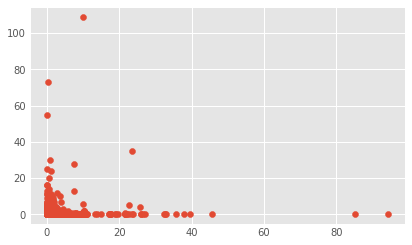

In [425]:
plt.scatter(y_pred, y_test)

In [398]:
#rfc.feature_importances_
features = np.append(vocab, cols_to_include)
importances = zip(rfc.feature_importances_,features)
sorted(importances, key=operator.itemgetter(0))[::-1]

[(0.30736057425249491, 'hour_6'),
 (0.078451899337900949, u'resolv'),
 (0.061701238914644199, u'rain'),
 (0.051979593183325387, u'outag'),
 (0.049259528318682355, 'dow_0'),
 (0.030712819909758493, u'restor'),
 (0.023417341248965603, u'asap'),
 (0.018780492002434077, u'connect'),
 (0.017275119637611674, u'us'),
 (0.017180689529050976, u'yesterday'),
 (0.015634427624315942, 'topic_0'),
 (0.015135212110297192, u'still'),
 (0.013495337327647124, 'dow_2'),
 (0.012958742900731188, 'dow_3'),
 (0.012834856177745343, u'transform'),
 (0.012746915460371617, 'hour_11'),
 (0.011515881723065653, 'hour_13'),
 (0.011008275721978818, u'power'),
 (0.010426499964604864, u'go'),
 (0.010241132489918401, u'follow'),
 (0.0099675220894711661, u'hey'),
 (0.0092755318313725299, u'kenya'),
 (0.0092217499809168664, u'experienc'),
 (0.0090549668762784797, 'hour_7'),
 (0.0083605719007602258, 'hour_10'),
 (0.0069178218997808126, 'hour_8'),
 (0.0061486824830676969, u'electr'),
 (0.0060758712781086716, u'sort'),
 (0.0

### Looking at key words

In [49]:
df = data

In [50]:
df['blackout'] =df['text'].str.contains('blackout')

In [51]:
df['outage'] = df['text'].str.contains('outage')

In [52]:
df['light'] = df['text'].str.contains('lights')

In [53]:
df['tokens'] = df['text'].str.contains('token')

In [54]:
df['maintenance'] = df['text'].str.contains('maintenance')

In [55]:
df['nairobi'] = df['text'].str.contains('nairobi')

In [56]:
df['power'] = df['text'].str.contains('power')

In [136]:
df['account']=df['text'].str.contains('account')

In [57]:
vocab[tfidf.sum(axis=0).argsort()[-10:]]

array([u'happen', u'yesterday', u'light', u'blackout', u'day', u'kindli',
       u'pleas', u'area', u'sinc', u'power'],
      dtype='<U9')

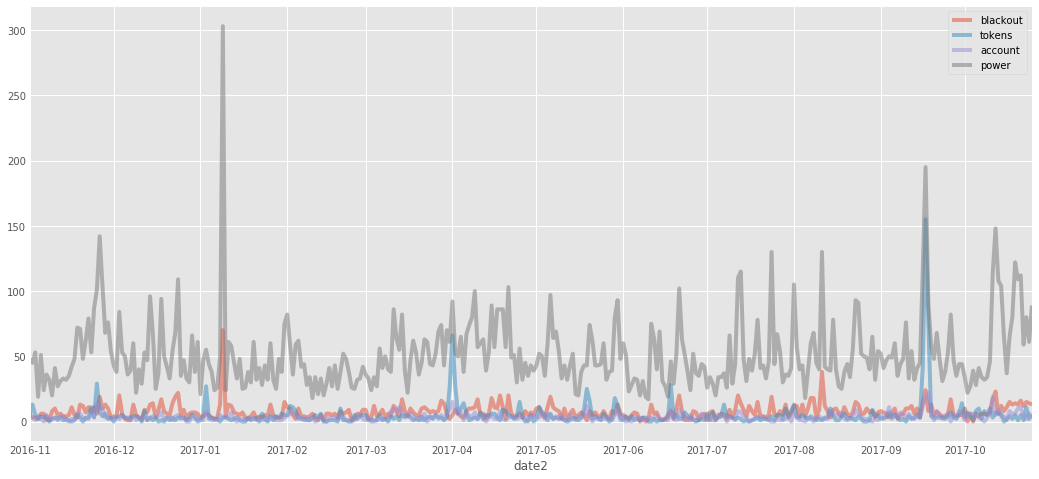

In [137]:
# df.groupby('date2')['username'].count().plot(kind='line',figsize=(16,8),alpha=0.5, label='total')
df.groupby('date2')['blackout'].sum().plot(kind='line',figsize=(16,8),alpha=0.5, label='blackout')
# df.groupby('date2')['light'].sum().plot(kind='line',figsize=(16,8),alpha=0.5,label='light')
df.groupby('date2')['tokens'].sum().plot(kind='line',figsize=(16,8),alpha=0.5,label='tokens')
df.groupby('date2')['account'].sum().plot(kind='line',figsize=(16,8),alpha=0.5,label='account')
df.groupby('date2')['power'].sum().plot(kind='line',figsize=(16,8),alpha=0.5,label='power')
plt.legend(loc='best')

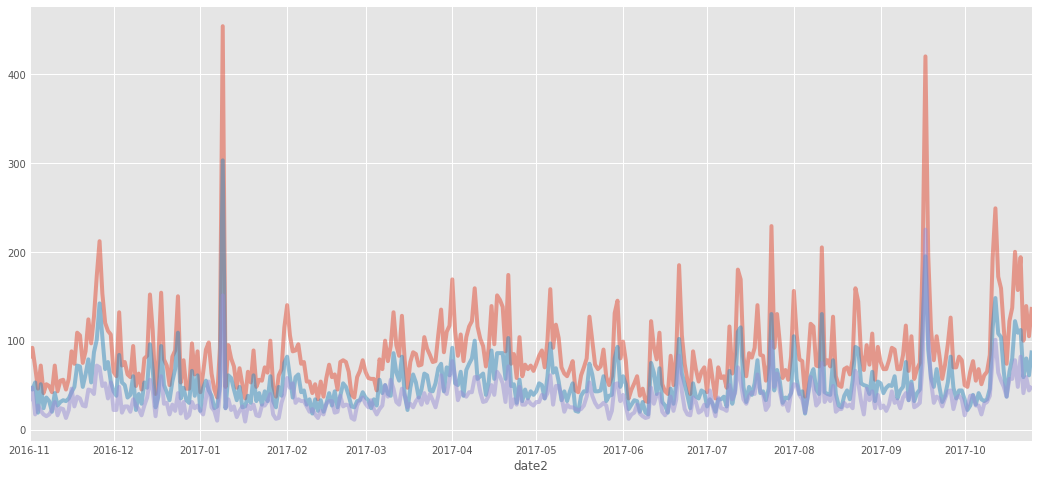

In [59]:
total_count = df.groupby('date2')['username'].count()
count_with_power = df.groupby('date2')['power'].sum()
difference = total_count - count_with_power
total_count.plot(kind='line',figsize=(16,8),alpha=0.5, label='total')
count_with_power.plot(kind='line',figsize=(16,8),alpha=0.5, label='power')
difference.plot(kind='line',figsize=(16,8),alpha=0.5, label='difference')

In [60]:
df['text'].head()

0    @KenyaPower_Care @KenyaPower @KenyaPowerAlert ...
1    @KenyaPowerAlert @KenyaPower what’s with the p...
2    For one week now there has no electricity in d...
3    @KenyaPower_Care @KenyaPowerAlert power outage...
4    @KenyaPower_Care @KenyaPowerAlert No power 284...
Name: text, dtype: object

In [61]:
def find_location(tweet, key_word, prefix=False):
    tweet = tweet.translate(None, string.punctuation)
    tweet = [t.lower() for t in tweet.split(' ')]
    if key_word in tweet:
        if prefix == False:
            location = tweet[tweet.index(key_word)-1:tweet.index(key_word)+1]
        else:
            location = tweet[tweet.index(key_word):tweet.index(key_word)+2]
        location.append('kenya')
        location = ' '.join(location)
    else:
        location = None
    return location

In [62]:
df['area'] = df['text'].apply(lambda x: find_location(x, 'area'))
df['road'] = df['text'].apply(lambda x: find_location(x, 'road'))
df['county'] = df['text'].apply(lambda x: find_location(x, 'county'))
df['estate'] = df['text'].apply(lambda x: find_location(x, 'estate'))
df['ward'] = df['text'].apply(lambda x: find_location(x, 'ward'))
df['town'] = df['text'].apply(lambda x: find_location(x, 'town'))
df['in'] = df['text'].apply(lambda x: find_location(x, 'in', True))




In [63]:
df.head(15)

,username,date,retweets,favorites,text,geo,mentions,hashtags,year,month,...,maintenance,nairobi,power,area,road,county,estate,ward,town,in
0,jossemwella,2017-10-25 12:32:00,0,0,@KenyaPower_Care @KenyaPower @KenyaPowerAlert ...,NaN,@KenyaPower_Care @KenyaPower @KenyaPowerAlert,NaN,2017,10,...,False,False,False,None,beach road kenya,None,village estate kenya,None,None,in beach kenya
1,kevinelegwa,2017-10-25 11:26:00,0,0,@KenyaPowerAlert @KenyaPower what’s with the p...,NaN,@KenyaPowerAlert @KenyaPower,NaN,2017,10,...,False,False,True,None,None,None,None,None,None,in nakuru kenya
2,EduWeez,2017-10-25 10:29:00,0,0,For one week now there has no electricity in d...,NaN,NaN,NaN,2017,10,...,False,False,False,None,None,None,None,None,None,in dandora kenya
3,wambuimugo,2017-10-25 08:34:00,0,0,@KenyaPower_Care @KenyaPowerAlert power outage...,NaN,@KenyaPower_Care @KenyaPowerAlert,NaN,2017,10,...,False,False,True,None,None,None,None,None,None,None
4,denniss_munene,2017-10-25 07:45:00,0,0,@KenyaPower_Care @KenyaPowerAlert No power 284...,NaN,@KenyaPower_Care @KenyaPowerAlert,NaN,2017,10,...,False,False,True,None,limuru road kenya,None,None,None,None,None
5,lilianngugi64,2017-10-25 07:09:00,0,0,@KenyaPower @KenyaPowerAlert @KenyaPower_Care ...,NaN,@KenyaPower @KenyaPowerAlert @KenyaPower_Care,NaN,2017,10,...,False,False,True,None,None,None,None,None,None,None
6,lizkmugo,2017-10-25 06:12:00,0,1,@KenyaPower @KenyaPower_Care @KenyaPowerAlert ...,NaN,@KenyaPower @KenyaPower_Care @KenyaPowerAlert,NaN,2017,10,...,False,False,True,None,None,None,None,None,None,None
7,kajujugicharuh,2017-10-25 05:19:00,0,0,"@KenyaPower , @KenyaPowerAlert kindly restore ...",NaN,@KenyaPower @KenyaPowerAlert,NaN,2017,10,...,False,False,True,None,None,None,None,None,None,None
8,ShiruMacharia,2017-10-25 03:26:00,0,0,"24 hours later were yet to assisted, is it bec...",NaN,NaN,NaN,2017,10,...,False,False,True,None,None,None,None,None,None,None
9,millergibbz,2017-10-24 10:16:00,0,0,So @KenyaPower @KenyaPowerAlert you have decid...,NaN,@KenyaPower @KenyaPowerAlert,NaN,2017,10,...,False,False,False,None,juja road kenya,None,None,None,None,None


In [65]:
df['road'].value_counts()

kenyatta road kenya             42
ojijo road kenya                42
the road kenya                  29
kangundo road kenya             27
naivasha road kenya             27
ngong road kenya                24
jogoo road kenya                23
limuru road kenya               21
kiambu road kenya               21
thika road kenya                21
nairobi road kenya              20
ack road kenya                  18
kikuyu road kenya               17
langata road kenya              15
riara road kenya                15
spine road kenya                14
kamiti road kenya               13
juja road kenya                 12
church road kenya               12
park road kenya                 12
outering road kenya             12
githunguri road kenya           12
kabete road kenya               11
mombasa road kenya              11
rhapta road kenya               11
gitanga road kenya              11
view road kenya                 10
popo road kenya                 10
north road kenya    

In [67]:
def get_coords(location):
    geolocator = Nominatim(country_bias='Kenya', timeout=4)
    if location == None:
        return None
    correct_coords = None
    geo_result = geolocator.geocode(location)
    if geo_result != None:
        coords = [geo_result.latitude, geo_result.longitude]
        correct_coords = coords
    return correct_coords


In [69]:
df['coords'] = df['road'].apply(lambda x : get_coords(x))

KeyboardInterrupt: 

In [468]:
df['coords_area'] = df['area'].apply(lambda x : get_coords(x))

KeyboardInterrupt: 

In [453]:
 geolocator = Nominatim(country_bias='Kenya', timeout=4)

In [460]:
geo_results = geolocator.geocode('migori town kenya')

In [461]:
[geo_results.latitude, geo_results.longitude]

[-1.0666, 34.4666]